In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, absolute_import
import sys
sys.path.append('/glade/work/yifanc/code/optmz/MO-ASMO/src/')
import numpy as np
import sampling
import gp
import NSGA2
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from os import path
import seaborn as sn
import pickle
import smt
from sklearn import preprocessing
import random
import re
from sklearn.metrics import mean_squared_error
import cmocean
import os
import hydroeval as he
import warnings
warnings.filterwarnings("ignore")


In [3]:
# 
init_iteration = 15 # 5 

# define the number of parameters in each updated run
N_resample = 20

location = 'pe_basin'

sheetname = 'T14'

num_init_sampling = 200

In [4]:
# define hyper parameters
pop = 100
gen = 100
crossover_rate = 0.9
mu = 20
mum = 20


In [5]:
# basin selected
#basin_sel = 'beaver' #'beaver'#'salcha'#'talkeetna'#'kenai' # 'kuparuk'
basin_list = ['beaver','talkeetna','salcha']
num_basin = len(basin_list)

# evaluation metric
evaluate_metric=['kge_daily','swe_metric']#['kge_daily','mape_max_swe']
nOutput = len(evaluate_metric)

In [6]:
metric_list = 'data/sm_metric/'
# metric_list = '/glade/work/yifanc/NNA/optmz/surrogate_model/metrics/'
# metric_list = '/glade/work/yifanc/NNA/optmz/single_basin/surrogate_model/metrics/%s/'%(basin_sel)
namelist_file = 'data/lnd_in'
basepftfile = 'data/clm50_params.c210607.nc'
# source_dir = '/glade/work/yifanc/NNA/optmz/'
source_dir = 'data/'

In [7]:
#baseline

baseline_dir = 'workflow/surrogate_model/metrics/baseline/'
metric_baseline = pd.DataFrame()
swe_metric_b_sum = pd.DataFrame([])
flow_metric_b_sum = pd.DataFrame([])

swe_metric_b_all = pd.DataFrame([])

for basin in basin_list: #['kuparuk','kenai', 'talkeetna', 'salcha', 'beaver']:
    
    flow_metric_b = pd.read_csv(baseline_dir + 'metric.flow.hs_ds_pe_OM_4km_baseline_%s.csv'%(basin), header=None, index_col=[0])
    flow_metric_b.columns=[basin]
    flow_metric_b_sum = pd.concat([flow_metric_b_sum,flow_metric_b.T])
    swe_metric_b = pd.read_csv(baseline_dir + 'metric.swe.hs_ds_pe_OM_4km_baseline_%s.csv'%(basin), index_col=[0])
    swe_metric_cal = np.sqrt(pow(swe_metric_b,2).sum(axis=1))
    swe_metric_b_sum = pd.concat([swe_metric_b_sum,swe_metric_cal])
    swe_metric_b_all = pd.concat([swe_metric_b_all,swe_metric_b])

In [8]:
swe_metric_b_sum

,0
SNOTEL:946_AK_SNTL,0.532449
SNOTEL:1035_AK_SNTL,0.850064
SNOTEL:1103_AK_SNTL,0.757236
SNOTEL:1002_AK_SNTL,0.445946
SNOTEL:967_AK_SNTL,0.381990
SNOTEL:947_AK_SNTL,0.574528
SNOTEL:949_AK_SNTL,0.576650
SNOTEL:948_AK_SNTL,0.542062
SNOTEL:950_AK_SNTL,0.720523
SNOTEL:951_AK_SNTL,0.663044


In [9]:
metric_baseline_mean = pd.DataFrame([[flow_metric_b_sum.mean()[0]],[swe_metric_b_sum.mean()[0]]],index=evaluate_metric, columns=['baseline'])
# calculate the objective function
metric_baseline_mean_norm = metric_baseline_mean.copy()
metric_baseline_mean_norm.loc['kge_daily','baseline'] = 1 - metric_baseline_mean_norm.loc['kge_daily','baseline']
metric_baseline_mean_norm = metric_baseline_mean_norm.dropna()

In [10]:
metric_baseline_mean_norm

,baseline
kge_daily,0.535781
swe_metric,0.604449


In [11]:
# update metric list
evaluate_metric=metric_baseline_mean_norm.index.values
nOutput = len(evaluate_metric)

In [12]:
param_df = pd.DataFrame([])
job_id_list = np.array([])

for iter_ in range(0, init_iteration+1):
    job_id_file = source_dir + 'workflow/pe_basin_%s.main_run.txt'%(iter_)
    param_pertubed_file = source_dir + 'workflow/pe_basin_%s.param_list.txt'%(iter_)
    # read the file
    param_df_temp = pd.read_csv(param_pertubed_file,index_col=[0])
    job_id_df = pd.read_csv(job_id_file,header=None)
    job_id_list_temp = job_id_df[0].values
    
    if iter_ == 0:
        num_init_jobs = len(job_id_list_temp)
    # concat parameter file and job id list
    param_df = pd.concat([param_df,param_df_temp])
    job_id_list = np.concatenate([job_id_list, job_id_list_temp])

In [13]:
num_param = param_df.shape[1]

In [14]:
soil_param_list = ['om_frac_sf','slopebeta']

In [15]:
# metric_mean = pd.DataFrame(np.zeros([2,len(job_id_list)]),
#                            index=['kge_daily','swe_metric'], 
#                            columns=job_id_list)
# df_none_nan_count = metric_mean.copy()

metric_mean = pd.DataFrame([])

flow_metric_sum_site = pd.DataFrame([])
swe_metric_sum_site = pd.DataFrame([])

init_job_list = []
optimized_job_list = []

swe_metric_all = pd.DataFrame([])

for i,job_id in enumerate(job_id_list):
    swe_metric_sum = pd.DataFrame([])
    flow_metric_sum = pd.DataFrame([])
    num_flow_metric_avail = 0
    for basin in basin_list:
        
        flow_file = metric_list+'metric.flow.%s_%s.csv'%(job_id,basin)
        
        if path.isfile(flow_file):        
            flow_metric = pd.read_csv(flow_file, header=None, index_col=[0])
            flow_metric.columns=[basin]
            flow_metric_sum = pd.concat([flow_metric_sum,flow_metric.T])
            
            swe_metric = pd.read_csv(metric_list+'metric.swe.%s_%s.csv'%(job_id,basin), index_col=[0])
            swe_metric_cal = np.sqrt(pow(swe_metric,2).sum(axis=1))
            swe_metric_sum = pd.concat([swe_metric_sum,swe_metric_cal])
            num_flow_metric_avail += 1
            
            swe_metric['ID'] = job_id
            swe_metric_all = pd.concat([swe_metric_all,swe_metric])
            
        else:
            print(basin, job_id, np.round(param_df.loc[job_id,soil_param_list].values.astype(np.float),decimals=3))
            flow_metric = pd.DataFrame([np.NaN], columns=['kge_daily'], index=[basin])
            flow_metric_sum = pd.concat([flow_metric_sum,flow_metric])
    if num_flow_metric_avail == num_basin: 
        if (i<num_init_jobs):
            init_job_list.append(job_id)
        else:
            optimized_job_list.append(job_id)
        
#     print(flow_metric_sum, flow_metric_sum.mean()[0])
    flow_metric_sum.columns = [job_id]
    swe_metric_sum.columns = [job_id]
    flow_metric_sum_site = pd.concat([flow_metric_sum_site,flow_metric_sum],axis=1)
    swe_metric_sum_site = pd.concat([swe_metric_sum_site,swe_metric_sum],axis=1)
    metric_exp = pd.DataFrame([[flow_metric_sum.mean(skipna=False)[0]],[swe_metric_sum.mean(skipna=False)[0]]], index=['kge_daily','swe_metric'],columns=[job_id])
    metric_mean = pd.concat([metric_mean,metric_exp],axis=1)

In [16]:
len(init_job_list)

200

In [17]:
# normalize the metrics
norm_metric_mean = metric_mean.copy()
norm_metric_mean.loc['kge_daily',:] = 1 - norm_metric_mean.loc['kge_daily',:]
norm_metric_mean = norm_metric_mean.dropna(axis=1)
num_init_sampling_remining = len(init_job_list)

In [18]:
norm_metric_mean.min(axis=1)

kge_daily     0.291407
swe_metric    0.391497
dtype: float64

# get the range of the parameters

In [19]:
# get the upper and lower bound of the parameter files
f = open(namelist_file, "r")
namelist_f = pd.DataFrame([],columns=['value'])
for x in f:
    string_list = x.split(sep='=')
    st_list = []
    for st in string_list:
        st_list.append(st.strip())
    if len(st_list) == 2:
        df = pd.DataFrame([st_list[1]],columns=['value'],index=[st_list[0]])
        namelist_f = pd.concat([namelist_f,df],axis=0)
        
# read in parameter files
param_ds = xr.open_dataset(basepftfile)

# load parameter name and range
pf = pd.read_csv("data/final_list_params_asmo.csv")
#pf = pf[pf['whether_asmo']=='y']
pf = pf[(pf['whether_asmo']=='y')&(pf['only_in_fates']=='no')]
# pf = pd.read_csv('/glade/work/yifanc/NNA/optmz/workflow/param_pertubed.t1.210422.txt',sep='\t')
nInput = len(pf)
file_location = pf['location'].values
N_var_list = pf[pf['location']=='N']['Parameters'].values
P_var_list = pf[pf['location']=='P']['Parameters'].values

# define variable name for specific variables
var_min='min_asmo'
var_max='max_asmo'
var_pft_min = 'pft_mins'
var_pft_max = 'pft_maxs'
var_param = 'Parameters'
pf[var_min] = pf[var_min].astype(str)
pf[var_max] = pf[var_max].astype(str)
pft_type_sel = np.arange(79)#np.array([2,11,12]).astype(np.int32)


In [20]:
vmin_list = []
vmax_list = []
v_default_list = []
for row in pf.iterrows():
    param_name = row[1][var_param]
    if row[1]['location'] == 'N':
        default_value = namelist_f.loc[param_name]['value']
        if type(default_value) is str:
            default_value = float(default_value.split('d')[0])
        print(param_name,default_value)
        v_default_list.append(default_value)
        if 'percent' in row[1][var_min]:
            pct_min = float(row[1][var_min].split('percent')[0])
            pct_max = float(row[1][var_max].split('percent')[0])
            vmin_list.append(default_value*(1-pct_min/100))
            vmax_list.append(default_value*(1+pct_max/100))
        else:
            vmin_list.append(float(row[1][var_min]))
            vmax_list.append(float(row[1][var_max]))
    else:
        if row[1]['location'] == 'P':
            default_value = param_ds[param_name].values
            v_default_list.append(default_value)
            if 'percent' in row[1][var_min]:
                pct_min = float(row[1][var_min].split('percent')[0])
                pct_max = float(row[1][var_max].split('percent')[0])
                vmin_list.append(default_value*(1-pct_min/100))
                vmax_list.append(default_value*(1+pct_max/100))
            else:
                if row[1][var_min] == 'pft':
                    pft_mins = row[1][var_pft_min]
                    pft_maxs = row[1][var_pft_max]
                    pft_mins = np.array(pft_mins.split(',')).astype(np.float64)
                    pft_maxs = np.array(pft_maxs.split(',')).astype(np.float64)
                    vmin_list.append(pft_mins[pft_type_sel])
                    vmax_list.append(pft_maxs[pft_type_sel])
#                     print(pft_mins[pft_type_sel], pft_maxs[pft_type_sel])
                else:
                    if type(default_value) == np.ndarray:
                        vmin_list.append(np.full(default_value.shape,float(row[1][var_min])))
                        vmax_list.append(np.full(default_value.shape,float(row[1][var_max])))
                    else:
                        vmin_list.append(float(row[1][var_min]))
                        vmax_list.append(float(row[1][var_max]))
pf['vmin_value'] = vmin_list
pf['vmax_value'] = vmax_list
pf['v_default'] = v_default_list

xlb = pf['vmin_value'].values
xub = pf['vmax_value'].values
x_default = pf['v_default'].values

upplim_destruct_metamorph 175.0


In [23]:
# x_default_value

In [21]:
xlb_single_value = []
xub_single_value = []
x_default_value = []

for i_param,param in enumerate(pf[var_param].values):
    lb = xlb[i_param]
    ub = xub[i_param]
    default = x_default[i_param]
    if type(lb) is not np.float64:
        xlb_single_value.append(np.mean(lb))
        xub_single_value.append(np.mean(ub))
        x_default_value.append(np.mean(default))
    else:
        xlb_single_value.append(lb)
        xub_single_value.append(ub)
        x_default_value.append(default)
        
xub_single_value = np.array(xub_single_value).astype(np.float64)
xlb_single_value = np.array(xlb_single_value).astype(np.float64)
x_default_single_value = np.array(x_default_value).astype(np.float64)

In [22]:
param_train_df = param_df.copy()

In [23]:
index_list = param_df.index.values
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *\-?\+?\ *[0-9]+)?')

for var in param_df.columns.values:
    if type(param_df.loc[index_list[0],var]) == str:
        v_list = []
        for index in index_list:
            my_list = [float(x) for x in re.findall(match_number, param_df.loc[index,var])]
#             my_list = np.array(re.findall(r'\d+\.\d+|\d+\.', param_df.loc[index,var])).astype(np.float32)
#             if len(my_list) == 0:
#                 my_list = np.array(re.findall(r'\d+\.', param_df.loc[index,var])).astype(np.float32)
            v_list.append(np.mean(my_list))
        param_train_df[var] = v_list

# normalize the parameters

In [24]:
# calculate normalization scalar
param_init_df = param_train_df.loc[init_job_list]
d = preprocessing.normalize(param_init_df,axis=0,return_norm=True)
normalization_scalar = d[1]

In [25]:
scaled_df = param_train_df/normalization_scalar
scaled_df.tail()

,fff,upplim_destruct_metamorph,d_max,e_ice,slopebeta,frac_sat_soil_dsl_init,medlynintercept,cv,n_melt_coef,om_frac_sf,liq_canopy_storage_scalar,krmax,a_coef,vcmaxha
pe_basin_15_0015,0.000122,0.119490,0.013331,0.109969,-0.043725,0.014338,0.113501,0.069248,0.013479,0.014339,0.002536,0.010108,0.034223,0.010388
pe_basin_15_0016,0.000186,0.112414,0.015971,0.109398,-0.054788,0.014335,0.122472,0.065041,0.013188,0.014335,0.003233,0.008934,0.034331,0.010507
pe_basin_15_0017,0.000177,0.106025,0.052205,0.112135,-0.049255,0.014335,0.119912,0.068024,0.007958,0.014346,0.000766,0.052022,0.038462,0.025073
pe_basin_15_0018,0.000122,0.085604,0.023499,0.114065,-0.040893,0.014433,0.116463,0.046992,0.025134,0.014482,0.000763,0.006505,0.034259,0.012620
pe_basin_15_0019,0.001422,0.120775,0.066649,0.113346,-0.055748,0.014339,0.113487,0.076316,0.005005,0.014520,0.000763,0.055344,0.037402,0.030655


In [26]:
xlb_single_value_scaled = xlb_single_value/normalization_scalar
xub_single_value_scaled = xub_single_value/normalization_scalar

In [27]:
bound_df = pd.DataFrame(np.transpose([xlb_single_value,xub_single_value,x_default_single_value]),index=param_df.columns.values,columns=['lb','ub','default'])
bound_scale_df = bound_df.divide(normalization_scalar,axis=0)

In [28]:
available_id_list = norm_metric_mean.columns.values

In [29]:
normalization_scalar

array([8.16902590e+01, 4.12390187e+03, 8.37653214e+02, 6.97613521e+01,
       8.37653214e+01, 1.74403380e+01, 1.63302889e+05, 3.37267570e-01,
       5.00415117e+03, 1.74403380e+01, 3.27623018e+01, 5.65485228e-08,
       1.47195873e+00, 2.12759127e+06])

In [30]:
# start training the surrogate models
x = scaled_df.loc[available_id_list].values #param_df.values #.shape[0]
y = norm_metric_mean.loc[evaluate_metric].T.values #norm_metric_mean.T.values


In [31]:
len(init_job_list),len(optimized_job_list)

(200, 300)

# train a surrogate model

2.5 0 (400, 14)
2.5 1 (400, 14)
2.5 2 (400, 14)
2.5 3 (400, 14)
2.5 4 (400, 14)
2.5 0.03776591772238001 0.026600108976493158 (400, 14)


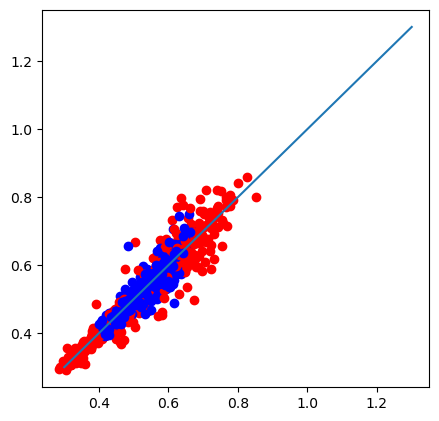

In [32]:
k_fold = 5
tot_sample_size = norm_metric_mean.shape[1]
num_validate_per_k = tot_sample_size/k_fold
num_train_per_k = tot_sample_size - num_validate_per_k

tot_id_list = np.arange(tot_sample_size)

# shuffle the id list
random.shuffle(tot_id_list)

alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 2.5

plt.figure(figsize=[5,5],dpi=100)
for alpha in [alpha]:
    rmse_list = []
    rmse_list_swe = []
    for k in range(k_fold):
#        validate_id_list = np.arange(k*num_validate_per_k,(k+1)*num_validate_per_k).astype(np.int)
        validate_id_list = tot_id_list[int(k*num_validate_per_k):int((k+1)*num_validate_per_k)]
        train_id_list = np.array(list(set(tot_id_list).difference(validate_id_list)))
    #     print(train_id_list, validate_id_list)

        x_train = x[train_id_list, :]
        x_val = x[validate_id_list, :]

        y_train = y[train_id_list, :]
        y_val = y[validate_id_list, :]

        sm_test = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[0], xlb_single_value_scaled, xub_single_value_scaled, alpha=alpha, leng_sb=[lb,ub],nu=nu)
        y_predict = sm_test.predict(x_val)

        rmse_list.append(np.sqrt(pow(y_predict[:,0] - y_val[:,0], 2).mean()))
        print(nu, k, x_train.shape)
        plt.scatter(y_predict.T[0],y_val.T[0],color='r')
        if nOutput == 2:
            plt.scatter(y_predict.T[1],y_val.T[1],color='b')
            rmse_list_swe.append(np.sqrt(pow(y_predict[:,1] - y_val[:,1], 2).mean()))
    print(nu, np.mean(rmse_list), np.mean(rmse_list_swe), x_train.shape)

plt.plot([0.3,1.3],[0.3,1.3])
# plt.xlim(0.3,1.3)
# plt.ylim(0.3,1.3)
# sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_single_value, xub_single_value, alpha=1e-4)

In [34]:
# np.sqrt(pow(y_predict[:,1] - y_val[:,1], 2).mean()),np.sqrt(pow(y_predict[:,0] - y_val[:,0], 2).mean())

# train a surrogate model

In [35]:
alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 2.5

sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_single_value_scaled, xub_single_value_scaled,alpha=alpha, leng_sb=[lb,ub], nu=nu)

In [36]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Pareto surface in the runs

In [37]:
# start training the surrogate models
x = scaled_df.loc[available_id_list].values #param_df.values #.shape[0]
y = norm_metric_mean.loc[evaluate_metric].T.values #norm_metric_mean.T.values

In [38]:
best_scenario = 'pe_basin_13_0018'

best y for 0
best y for 1
best y for 2
best y for 3
best y for 4
best y for 5
best y for 6
best y for 7
best y for 8
best y for 9
best y for 10
best y for 11
best y for 12
best y for 13
best y for 14
best y for 15


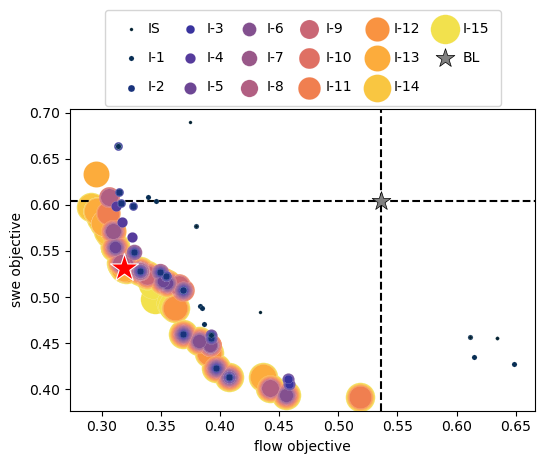

In [39]:
plt.figure(dpi=100)

flow_baseline = metric_baseline_mean_norm.loc['kge_daily','baseline']
if nOutput == 2:
    swe_baseline = metric_baseline_mean_norm.loc['swe_metric','baseline']

for i in range(init_iteration+1):
    zorder = init_iteration + 1 -i
    size= ((i+2)*1.25)**2
    lw = 0.5*(i+1)
    theme_color= cmocean.cm.thermal((i)/(init_iteration+1))
#     if i == 0:
#         best_pre = metric_baseline_mean_norm['baseline']
#     else:
#         best_pre = best
    if init_iteration == 0:
        st_id = 0 
        ed_id = num_init_sampling_remining
    else:
        st_id = num_init_sampling_remining + (i-1) * N_resample
        ed_id = num_init_sampling_remining + (i) * N_resample

    xtmp = x[0:ed_id,:]
    ytmp = y[0:ed_id,:]
    xtmp, ytmp, rank, crowd = NSGA2.sortMO(xtmp, ytmp, nInput, nOutput)
    idxp = (rank == 0)
    bestx = xtmp[idxp,:]
    besty = ytmp[idxp,:]
    print('best y for %s'%(i))
    if nOutput == 1:
        plt.hist(besty[:,0],color=theme_color)
        best_y_df = pd.DataFrame(besty, columns=['flow_metric'])
    else:
        if i == 0:
            lb = 'IS'
        else:
            lb = 'I-%s'%(i)
        plt.scatter(besty[:,0],besty[:,1],facecolor=theme_color, 
                    edgecolor='white',s=size, linewidths=0.1, zorder = zorder, label=lb)
        best_y_df = pd.DataFrame(besty, columns=['flow_metric','swe_metric'])
    
    # find the corresponding ID
    best_list_rank = []
    best_list_id = []
    for i in best_y_df.index.values:
        id_list = norm_metric_mean.columns.values
        rank_scenario = pow(norm_metric_mean.T.values - best_y_df.loc[i].values,2).sum(axis=1).argmin()
        best_list_rank.append(rank_scenario)
        best_list_id.append(id_list[rank_scenario])
    best_y_df['rank'] = best_list_rank
    best_y_df['id'] = best_list_id
    
    # sort the values by flow metrics
    best_y_df_sorted = best_y_df.sort_values('flow_metric')
#     plt.plot(best_y_df_sorted['flow_metric'],best_y_df_sorted['swe_metric'],c=theme_color, lw=lw)
# plt.ylim(0.4,0.7)
# plt.xlim(0.28,0.8)
a=plt.gca()
if nOutput == 2:
    plt.scatter(flow_baseline,swe_baseline,label='BL',marker = '*', edgecolor='k', facecolor='gray', s=200, zorder=10, linewidths=0.5)
    xlim = a.get_xlim()
    ylim = a.get_ylim()
    plt.plot([flow_baseline,flow_baseline],ylim,'k--', linewidth=1.5)
    plt.plot(xlim,[swe_baseline,swe_baseline],'k--', linewidth=1.5)
if nOutput == 1:
    xlim = a.get_xlim()
    ylim = a.get_ylim()
    plt.plot([flow_baseline,flow_baseline],ylim,'k--', linewidth=1.5)
    
# ylim = [ylim[0],ylim[1]+0.1]

# plot best selected scenario
flow_bs = best_y_df_sorted[best_y_df_sorted['id']==best_scenario]['flow_metric']
swe_bs = best_y_df_sorted[best_y_df_sorted['id']==best_scenario]['swe_metric']
plt.scatter(flow_bs,swe_bs,zorder=40,s= ((15+2)*1.25)**2, marker='*', facecolor='red', edgecolor='white', linewidths=0.8)

plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('flow objective')
plt.ylabel('swe objective')
# plt.title('Southern Basins')
plt.legend(loc=9, ncol=6,labelspacing=1.1,fontsize=10,columnspacing=0.8,handletextpad=0.2, borderpad=0.85, bbox_to_anchor=(0.5, 1.35))
plt.show()

In [40]:
best_scenario = 'pe_basin_13_0018' #'pe_basin_2_0008'
scaled_df.loc[best_scenario,param]

0.110535747006475

In [41]:
if nOutput == 2:
    best_y_df['metric_mean'] = (best_y_df['flow_metric'] + best_y_df['swe_metric'])/2
    best_y_df_sorted = best_y_df.sort_values('metric_mean')
else:
    best_y_df_sorted = best_y_df.sort_values('flow_metric')
best_y_df_sorted

,flow_metric,swe_metric,rank,id,metric_mean
7,0.396349,0.423125,228,pe_basin_2_0008,0.409737
4,0.407655,0.413355,223,pe_basin_2_0003,0.410505
3,0.368992,0.459392,221,pe_basin_2_0001,0.414192
6,0.390539,0.438787,430,pe_basin_12_0010,0.414663
8,0.382290,0.452528,303,pe_basin_6_0003,0.417409
12,0.345118,0.498305,487,pe_basin_15_0007,0.421712
11,0.442729,0.401669,342,pe_basin_8_0002,0.422199
2,0.455699,0.393255,304,pe_basin_6_0004,0.424477
5,0.436411,0.412907,443,pe_basin_13_0003,0.424659
25,0.359945,0.490374,495,pe_basin_15_0015,0.425159


In [42]:
param_train_df.loc[best_scenario]

fff                          1.000000e-02
upplim_destruct_metamorph    8.602326e+01
d_max                        4.980815e+01
e_ice                        7.994332e+00
slopebeta                   -6.935602e+00
frac_sat_soil_dsl_init       2.500000e-01
medlynintercept              7.326472e+03
cv                           1.707810e-02
n_melt_coef                  2.500000e+01
om_frac_sf                   5.255147e-01
liq_canopy_storage_scalar    3.695237e+00
krmax                        3.625946e-09
a_coef                       5.009386e-02
vcmaxha                      2.351749e+05
Name: pe_basin_13_0018, dtype: float64

In [43]:
#
units_list = ['1/m',r"$kg/m^3$",'mm','-','-','-',r"$\frac{umol H_2O}{m^2s}$",r"$m/s^{1/2}$",'-','-',r"$kg/m^2$",'1/s','-','J/mol']
# units_list = ['1/m',r"$kg/m^3$", r"$\frac{umol H_2O}{umol CO^2}$",'mm','-','-','-',r"$m/s^{1/2}$",'-','-','microns','1/s','-','J/mol']#,r"$kg/m^3$",r"$umol H_2O/m^2s$",'-','1/m'] + 5*['-']
units_list

['1/m',
 '$kg/m^3$',
 'mm',
 '-',
 '-',
 '-',
 '$\\frac{umol H_2O}{m^2s}$',
 '$m/s^{1/2}$',
 '-',
 '-',
 '$kg/m^2$',
 '1/s',
 '-',
 'J/mol']

In [44]:
x_default_single_value, metric_baseline_mean_norm

(array([ 5.00000000e-01,  1.75000000e+02,  1.50000000e+01,  6.00000000e+00,
        -3.00000000e+00,  8.00000000e-01,  1.00000000e+02,  1.00000000e-02,
         2.00000000e+02,  1.00000000e+00,  1.00000000e-01,  1.22297812e-09,
         1.30000000e-01,  7.20000000e+04]),
             baseline
 kge_daily   0.535781
 swe_metric  0.604449)

start w/ param fff
start w/ param upplim_destruct_metamorph
start w/ param d_max
start w/ param e_ice
start w/ param slopebeta
start w/ param frac_sat_soil_dsl_init
start w/ param medlynintercept
start w/ param cv
start w/ param n_melt_coef
start w/ param om_frac_sf
start w/ param liq_canopy_storage_scalar
start w/ param krmax
start w/ param a_coef
start w/ param vcmaxha


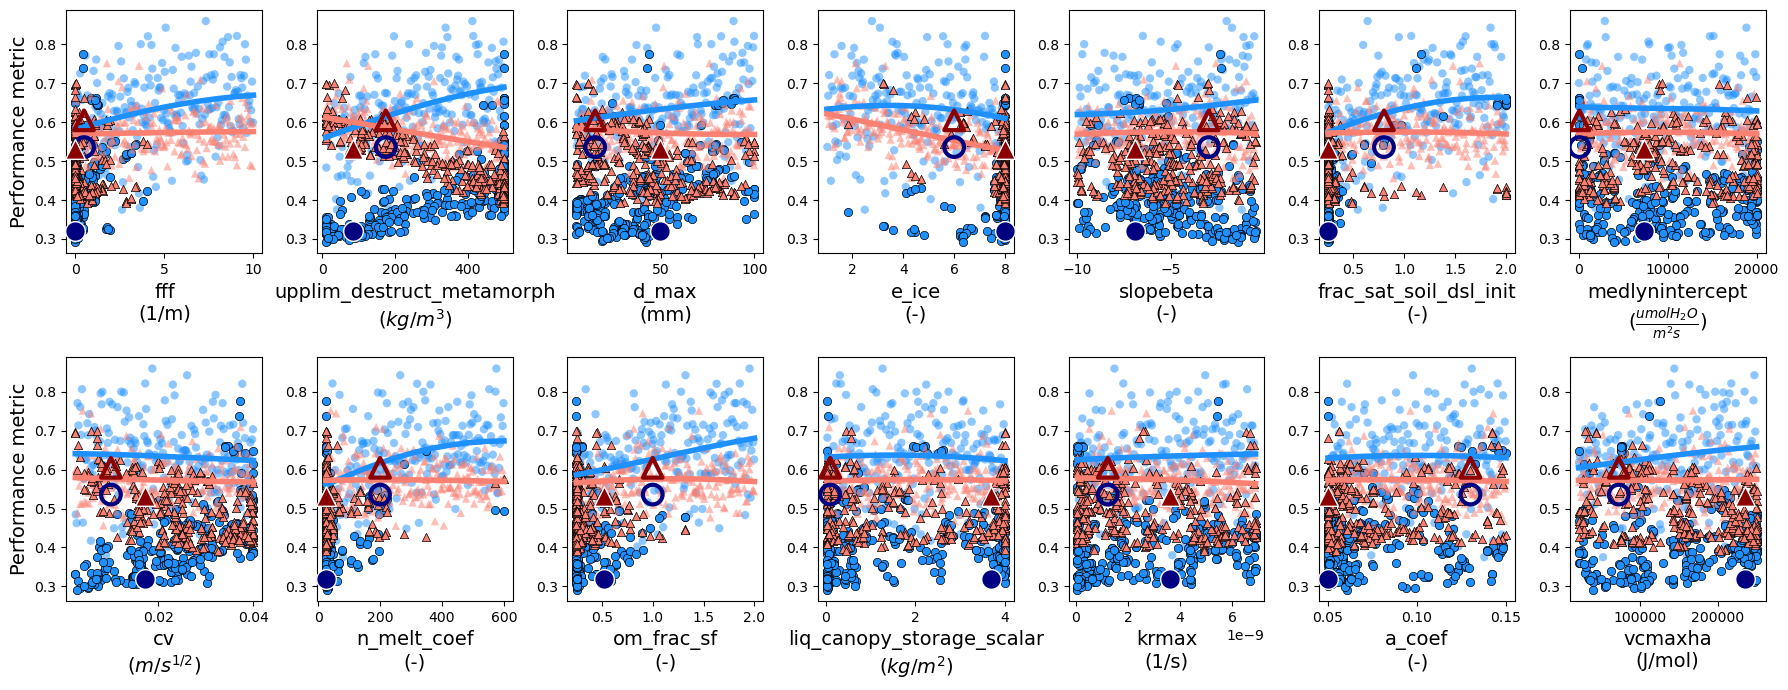

In [45]:
# best_scenario_list = ['pe_basin_2_0008','pe_basin_15_0007','pe_basin_13_0018']#'pe_basin_8_0013'
best_scenario_list = ['pe_basin_13_0018']
# for shapefile
fig,ax = plt.subplots(2,7,figsize=[18,7],dpi=100)
for i_param,param in enumerate(bound_scale_df.index.values):
    lb = bound_scale_df['lb'].loc[param]
    ub = bound_scale_df['ub'].loc[param]
    x_sim_list = []
    # for flow metric
    y_sim_mean_list = []
    y_sim_lb_list = []
    y_sim_ub_list = []
    # for swe metric
    y_sim_mean_swe_list = []
    y_sim_lb_swe_list = []
    y_sim_ub_swe_list = []
    
    # default parameters
    print('start w/ param %s'%(param))
    default_param = scaled_df.iloc[0:num_init_sampling_remining].values
    for j in range(11):
        x = default_param.copy()
        x_sim = lb + (ub-lb)*j/10
        x[:,i_param] = x_sim
        x_sim_list.append(x_sim)
        y_sim = sm.predict(x)
        y_sim_mean, y_sim_lb, y_sim_ub = mean_confidence_interval(y_sim[:,0])
        y_sim_mean_list.append(y_sim_mean)
        y_sim_lb_list.append(y_sim_lb)
        y_sim_ub_list.append(y_sim_ub)
        if nOutput == 2:
            y_sim_mean_swe, y_sim_lb_swe, y_sim_ub_swe = mean_confidence_interval(y_sim[:,1])
            y_sim_mean_swe_list.append(y_sim_mean_swe)
            y_sim_lb_swe_list.append(y_sim_lb_swe)
            y_sim_ub_swe_list.append(y_sim_ub_swe)
    col = i_param %7
    row = int(np.floor(i_param/7))
    x_sim_array = np.array(x_sim_list)*normalization_scalar[i_param]
    ax[row,col].plot(x_sim_array,y_sim_mean_list, lw=4, c='dodgerblue')
    ax[row,col].scatter(param_train_df.loc[init_job_list,param].values, norm_metric_mean.T['kge_daily'].loc[init_job_list], marker='o', facecolor='dodgerblue', edgecolor="none", alpha=0.5)
    ax[row,col].scatter(x_default_single_value[i_param], metric_baseline_mean_norm.loc['kge_daily'].values, marker='o', facecolor='none', edgecolor="navy", lw=3, s=200, zorder=10)

    for best_scenario in best_scenario_list:
        ax[row,col].scatter(param_train_df.loc[best_scenario,param], norm_metric_mean.T['kge_daily'].loc[best_scenario], marker='o', facecolor='navy', edgecolor="white", s=200, zorder=10)
    if init_iteration>0:
        ax[row,col].scatter(param_train_df.loc[optimized_job_list,param].values, norm_metric_mean.T['kge_daily'].loc[optimized_job_list], marker='o', facecolor='dodgerblue', edgecolor="k", lw=0.5, alpha=1)
    if nOutput == 2:
        ax[row,col].plot(x_sim_array,y_sim_mean_swe_list, lw=4, c='salmon')
        ax[row,col].scatter(param_train_df.loc[init_job_list,param].values, norm_metric_mean.T['swe_metric'].loc[init_job_list], marker='^', facecolor='salmon', edgecolor="none", alpha=0.5)
        ax[row,col].scatter(x_default_single_value[i_param], metric_baseline_mean_norm.loc['swe_metric'].values, marker='^', facecolor='none', edgecolor="darkred", lw=3, s=200, zorder=10)

        for best_scenario in best_scenario_list:
            ax[row,col].scatter(param_train_df.loc[best_scenario,param], norm_metric_mean.T['swe_metric'].loc[best_scenario], marker='^', facecolor='darkred', edgecolor="white", s=200, zorder=10)
        if init_iteration>0:
            ax[row,col].scatter(param_train_df.loc[optimized_job_list,param].values, norm_metric_mean.T['swe_metric'].loc[optimized_job_list], marker='^', facecolor='salmon', edgecolor="k", lw=0.5, alpha=1)
    
    if col == 0:
        ax[row,col].set_ylabel('Performance metric', fontsize=14)
#     if row == 4:
#        ax[row,col].set_xlabel('Normalized parameter value')
    ax[row,col].set_xlabel(param + '\n(%s)'%(units_list[i_param]), fontsize=14)
# fig.suptitle('Southern three basins',fontweight ="bold", fontsize=30)
# ax[-1, -1].axis('off')
plt.tight_layout()
